# Credit Markets
## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

* Alex Popovici
* alex.popovici@uchicago.edu

# Basic Usage of QuantLib analytics library
## More details at: https://quantlib-python-docs.readthedocs.io/en/latest/

- 1\. Objects and Handles
  - a. Define a quote object and inspect the value
  - b. Define quoteHandle as a handle/smart pointer to the quote object    
  - c. Calendars and day-count conventions
- 2\. Cashflow Schedules
  - a. Construct semi-annual cashflow schedule object, for fixed-rate bonds
  - b. Inspect the semi-annual cashflow schedule
  - c. Construct quarterly cashflow schedule object, for floating-rate bonds
  - d. Inspect the quarterly cashflow schedule
- 3\. Discount Curve / Yield Curve Term Structure
  - a. Constructing a Flat Yield Curve
  - b. Inspect the discount curve
- 4\. Fixed and Floating Rate Bonds
  - a. Constructing a fixed rate bond object
  - b. Investigate the fixed-rate bond cash-flows
  - c. Constructing a floating rate bond object: linked to SOFR index
- 5\. Bond Present Value Calculation (no credit risk)
  - a. Direct function call using risk-free bond pricing engine
  - b. Manual Calculation to validate PV (for fixed and floating-rate bonds)
  - c. Bond Clean vs Dirty Prices (adjusted to settle date)
- 6\. Market Data Scenarios
  - a. Apply +/-1bp parallel shift scenarios in interest rates curve and compute scenario prices
  - b. Compute scenario DV01, duration and convexity
  - c. Yield to Price conversions
  - d. Price to Yield conversions
- 7\. Analytical Duration, Convexity and Z-Spread (flat yield model)
  - a. Compute bond duration, convexity and Z-Spread   
  - b. Validate Z-Spread
- 8\. Treasury Yield Curve Calibration (via Bootstrapping)
  - a. Calibrate treasury flat yield curve (simple case of one calibration instrument)
  - b. Display the calibrated Treasury discount curve dataframe
  - c. Plot the calibrated Treasury Zero Rates and Discount Factors curves
  - d. Reprice the bond on the yield curve to validate the calibration

In [118]:
import QuantLib as ql
import numpy as np
import pandas as pd

------------------------------------------------------------------------------------------
# 1. Objects and Handles
## a. Define a quote object and inspect the value.

In [119]:
quote = ql.SimpleQuote(.01)
print(quote.value())

quote.setValue(.02)
print(quote.value())

0.01
0.02


## b. Define quoteHandle as a handle/smart pointer to the quote object

In [120]:
quoteHandle = ql.QuoteHandle(quote)
quoteHandle.value()

0.02

### When the quote object is changed, the quoteHandle changes value as well

In [121]:
quote.setValue(.03)
quoteHandle.value()

0.03

## c. Calendars and day-count conventions

In [122]:
# dates
todays_date = ql.Date.todaysDate()
test_date = todays_date + 90
print('todays_date =', todays_date)
print('test_date =', test_date)


# calendars
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
holiday_list = list(calendar.holidayList(todays_date, test_date))
print('holiday_list =', holiday_list)


# day count conventions
day_count = ql.Actual360()
print('day_count =', day_count)

# year fractions
test_year_fraction = day_count.yearFraction(todays_date, test_date)
print('Year Fraction  from', todays_date, 'to', test_date,'] =', test_year_fraction)

todays_date = March 29th, 2025
test_date = June 27th, 2025
holiday_list = [Date(18,4,2025), Date(26,5,2025), Date(19,6,2025)]
day_count = Actual/360 day counter
Year Fraction  from March 29th, 2025 to June 27th, 2025 ] = 0.25


------------------------------------------------------------------------------------------
# 2. Cashflow Schedules
## a. Construct semi-annual cashflow schedule object, for fixed-rate bonds

In [123]:
issue_date = ql.Date(1, 4, 2025)        # 2025-04-01
maturity_date = ql.Date(1, 4, 2029)     # 2028-04-01
coupon_freq = ql.Semiannual
coupon_term = ql.Period(coupon_freq)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
business_day_conv = ql.Unadjusted
date_generation = ql.DateGeneration.Backward
month_end = True

# fixed_rate_schedule
fixed_rate_schedule = ql.Schedule(issue_date,
                       maturity_date,
                       coupon_term,
                       calendar,
                       business_day_conv,
                       business_day_conv,
                       date_generation,
                       month_end)

## b. Inspect the semi-annual cashflow schedule
- Use list() to get a list of all the dates in Schedule, and len() to get number of dates
- Use []] for random access
- Use startDate(), endDate()

In [124]:
print("All dates: ", list(fixed_rate_schedule))
print("Length: ", len(fixed_rate_schedule))
print("The 3rd coupon date: ", fixed_rate_schedule[2])  # random access
print("Start Date: ", fixed_rate_schedule.startDate())
print("End Date: ", fixed_rate_schedule.endDate())

All dates:  [Date(1,4,2025), Date(1,10,2025), Date(1,4,2026), Date(1,10,2026), Date(1,4,2027), Date(1,10,2027), Date(1,4,2028), Date(1,10,2028), Date(1,4,2029)]
Length:  9
The 3rd coupon date:  April 1st, 2026
Start Date:  April 1st, 2025
End Date:  April 1st, 2029


## c. Construct quarterly cashflow schedule object, for floating-rate bonds

In [125]:
# floating_rate_bond_schedule
floating_rate_schedule = ql.Schedule(
    issue_date,
    maturity_date,
    ql.Period(ql.Quarterly),
    calendar,
    business_day_conv,
    business_day_conv,
    date_generation,
    month_end,
)

## d. Inspect the quarterly cashflow schedule

In [126]:
print("All dates: ", list(floating_rate_schedule))
print("Length: ", len(floating_rate_schedule))
print("The 3rd coupon date: ", floating_rate_schedule[2])  # random access
print("Start Date: ", fixed_rate_schedule.startDate())
print("End Date: ", fixed_rate_schedule.endDate())

All dates:  [Date(1,4,2025), Date(1,7,2025), Date(1,10,2025), Date(1,1,2026), Date(1,4,2026), Date(1,7,2026), Date(1,10,2026), Date(1,1,2027), Date(1,4,2027), Date(1,7,2027), Date(1,10,2027), Date(1,1,2028), Date(1,4,2028), Date(1,7,2028), Date(1,10,2028), Date(1,1,2029), Date(1,4,2029)]
Length:  17
The 3rd coupon date:  October 1st, 2025
Start Date:  April 1st, 2025
End Date:  April 1st, 2029


------------------------------------------------------------------------------------------
# 3. Discount Curve / Yield Curve Term Structure
## a. Constructing a Flat Yield Curve

In [127]:
# Set the static valuation/calculation date: 2025-04-01
calc_date = ql.Date(1, 4, 2025)
ql.Settings.instance().evaluationDate = calc_date

# using 5% flat interest rate for testing
flat_rate = ql.SimpleQuote(0.05)
rate_handle = ql.QuoteHandle(flat_rate)
day_count = ql.Actual360()
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
continuous_comp = ql.Continuous # continously compounded rate of 5%

# Create flat yield curve with continously compounded rate of 5%
flat_yield_curve = ql.FlatForward(calc_date, rate_handle, day_count, continuous_comp)

# Add handle for yield curve
flat_yield_curve_handle = ql.YieldTermStructureHandle(flat_yield_curve)

## b. Inspect the discount curve

In [128]:
ref_date = flat_yield_curve.referenceDate()
test_date = ql.Date(1, 9, 2025)

# calc year fraction between ref_date and test_date
yearFrac = flat_yield_curve.dayCounter().yearFraction(ref_date, test_date)

print("Reference Date =", ref_date)
print("Test Date =", test_date)
print("Year Fraction between Reference Date and Test Date : ", yearFrac)
print("Discount Factor for Test Date", test_date, ": ", flat_yield_curve.discount(test_date))
print("custom DF calculation for Test Date", test_date, ": ", np.exp(-flat_rate.value() * yearFrac))
print("Difference in Discount Factor:", flat_yield_curve.discount(test_date) - np.exp(-flat_rate.value() * yearFrac))



Reference Date = April 1st, 2025
Test Date = September 1st, 2025
Year Fraction between Reference Date and Test Date :  0.425
Discount Factor for Test Date September 1st, 2025 :  0.97897419042636
custom DF calculation for Test Date September 1st, 2025 :  0.97897419042636
Difference in Discount Factor: 0.0


------------------------------------------------------------------------------------------
# 4. Fixed and Floating Rate Bonds
## a. Constructing a fixed rate bond object

In [129]:
# day_count: ACT/ACT for Govt bonds
day_count_govt = ql.ActualActual(ql.ActualActual.ISMA)

# day_count: 30/360 for fixed-rate Corp bonds
day_count_corp_fixed = ql.Thirty360(ql.Thirty360.USA)

# day_count: ACT/360 for floating-rate bonds
day_count_floater = ql.Actual360()


# settlement_days: 1 for Govt and Corp bonds
settlement_days = 1

# Govt Bonds specs
day_count = day_count_govt

# coupon = 5%
coupon_rate = 5 * 1e-2
coupons = [coupon_rate]

# business days convention
business_days_conv = ql.Unadjusted

# face_value
face_value = 100


# Construct the fixed_rate_bond
face_value = 100
fixed_rate_bond = ql.FixedRateBond(
    settlement_days,
    face_value,
    fixed_rate_schedule,
    coupons,
    day_count,
    business_days_conv)

## b. Investigate the fixed-rate bond cash-flows

        CashFlowDate  CashFlowAmount
0  October 1st, 2025             2.5
1    April 1st, 2026             2.5
2  October 1st, 2026             2.5
3    April 1st, 2027             2.5
4  October 1st, 2027             2.5
5    April 1st, 2028             2.5
6  October 1st, 2028             2.5
7    April 1st, 2029             2.5
8    April 1st, 2029           100.0


<Axes: xlabel='CashFlowDate'>

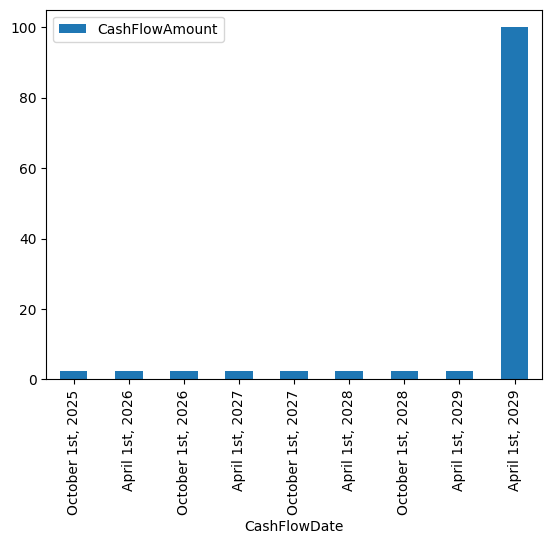

In [130]:
# extract cashflow dates and amounts from fixed rate bond
x = [(cf.date(), cf.amount()) for cf in fixed_rate_bond.cashflows()]
cf_date_fixed, cf_amount = zip(*x)

# create and display cashflows dataframe
cf_frame_fixed = pd.DataFrame(data={'CashFlowDate': cf_date_fixed, 'CashFlowAmount': cf_amount})
print(cf_frame_fixed)

# plot cashflows
cf_frame_fixed.plot.bar(x='CashFlowDate', y='CashFlowAmount')

## c. Constructing a floating rate bond object: linked to SOFR index

In [131]:
# sofr_term_structure_handle: using 5% flat interest rate for testing
soft_rate = 5 * 1e-2
rate_handle = ql.QuoteHandle(ql.SimpleQuote(soft_rate))
sofr_term_structure = ql.FlatForward(calc_date, rate_handle, day_count_floater, ql.Continuous)
sofr_term_structure_handle = ql.YieldTermStructureHandle(sofr_term_structure)

# Set SOFR index history
im = ql.IndexManager.instance()
sofr_index = ql.Sofr(sofr_term_structure_handle)

# Set SOFR fixings
im.clearHistory(sofr_index.name())
sofr_index.addFixing(ql.Date(28, ql.March, 2025), soft_rate)
sofr_index.addFixing(ql.Date(31, ql.March, 2025), soft_rate)

# Set floating rate spread: 25bps
floating_rate_spread = 25 * 1e-6
spreads=[floating_rate_spread]

# floating_rate_bond
floating_rate_bond = ql.FloatingRateBond(settlement_days,
                                face_value,
                                floating_rate_schedule,
                                sofr_index,
                                day_count_floater,
                                business_days_conv,
                                spreads=spreads, # 25 bps floating rate
                                issueDate=issue_date)


         CashFlowDate  CashFlowAmount
0      July 1st, 2025        1.272542
1   October 1st, 2025        1.286615
2   January 1st, 2026        1.286705
3     April 1st, 2026        1.258558
4      July 1st, 2026        1.272542
5   October 1st, 2026        1.286615
6   January 1st, 2027        1.286884
7     April 1st, 2027        1.258558
8      July 1st, 2027        1.272542
9   October 1st, 2027        1.286615
10  January 1st, 2028        1.286794
11    April 1st, 2028        1.272807
12     July 1st, 2028        1.272807
13  October 1st, 2028        1.286794
14  January 1st, 2029        1.286884
15    April 1st, 2029        1.258820
16    April 1st, 2029      100.000000


<Axes: xlabel='CashFlowDate'>

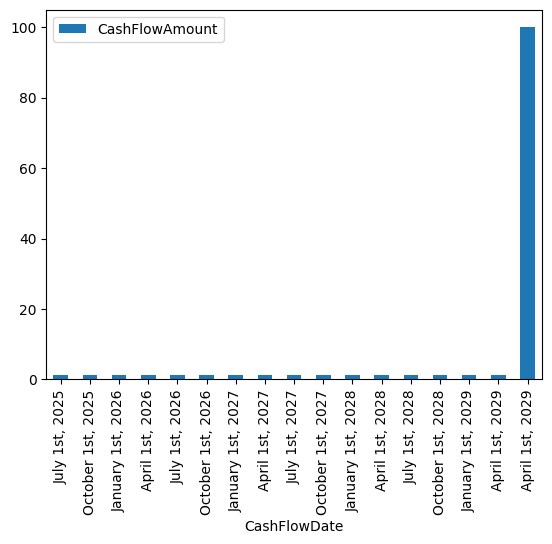

In [132]:
# extract cashflow dates and amounts from floating rate bond
x = [(cf.date(), cf.amount()) for cf in floating_rate_bond.cashflows()]
cf_date_float, cf_amount = zip(*x)

# create and display cashflows dataframe
cf_frame_float = pd.DataFrame(data={'CashFlowDate': cf_date_float, 'CashFlowAmount': cf_amount})
print(cf_frame_float)

# plot cashflows
cf_frame_float.plot.bar(x='CashFlowDate', y='CashFlowAmount')

------------------------------------------------------------------------------------------
# 5. Bond Present Value Calculation (no credit risk)
## a. Direct function call using risk-free bond pricing engine

In [133]:
# Create risk-free discounting engine
bond_engine = ql.DiscountingBondEngine(flat_yield_curve_handle)

# fixed_rate_bond PV
fixed_rate_bond.setPricingEngine(bond_engine)
fixed_rate_bond_pv = fixed_rate_bond.NPV()
print('fixed_rate_bond_pv =', fixed_rate_bond_pv)

# floating_rate_bond PV
floating_rate_bond.setPricingEngine(bond_engine)
floating_rate_bond_pv = floating_rate_bond.NPV()
print('floating_rate_bond_pv =', floating_rate_bond_pv)

fixed_rate_bond_pv = 99.50727882766412
floating_rate_bond_pv = 100.01088539188409


## b. Manual Calculation to validate PV (for fixed and floating-rate bonds)

In [134]:
# Validate fixed-rate bond PV
used_cf_frame = cf_frame_fixed
used_bond_pv = fixed_rate_bond_pv

# Validate floating-rate bond PV
# used_cf_frame = cf_frame_float
# used_bond_pv = floating_rate_bond_pv

ref_date = flat_yield_curve.referenceDate()

# Calc year fraction to cashflow date
used_cf_frame['YearFrac'] = [flat_yield_curve.dayCounter().yearFraction(ref_date, cf_date) for cf_date in used_cf_frame['CashFlowDate']]

# Calc risk-free discount factor cashflow date
used_cf_frame['DiscountFactor'] = [flat_yield_curve.discount(cf_date) for cf_date in used_cf_frame['CashFlowDate']]

# Calc NPV for each cashflow
used_cf_frame['NPV'] = used_cf_frame['CashFlowAmount'] * used_cf_frame['DiscountFactor']

display(used_cf_frame)

,CashFlowDate,CashFlowAmount,YearFrac,DiscountFactor,NPV
0,"October 1st, 2025",2.5,0.508333,0.974904,2.437259
1,"April 1st, 2026",2.5,1.013889,0.950569,2.376423
2,"October 1st, 2026",2.5,1.522222,0.926713,2.316783
3,"April 1st, 2027",2.5,2.027778,0.903582,2.258954
4,"October 1st, 2027",2.5,2.536111,0.880905,2.202262
5,"April 1st, 2028",2.5,3.044444,0.858797,2.146994
6,"October 1st, 2028",2.5,3.552778,0.837245,2.093112
7,"April 1st, 2029",2.5,4.058333,0.816346,2.040866
8,"April 1st, 2029",100.0,4.058333,0.816346,81.634627


In [135]:
# Manual computation of NPV
pv_manual = used_cf_frame['NPV'].sum()
print('NPV engine = ', used_bond_pv)
print('NPV manual = ', pv_manual)
print('NPV diff = ', pv_manual - used_bond_pv)

NPV engine =  99.50727882766412
NPV manual =  99.50727882766412
NPV diff =  0.0


## c. Bond Clean vs Dirty Prices (adjusted to settle date)

In [136]:
# The bond price is computed by adjusting the NPV to the trade settle date
print('Bond Notional = ', fixed_rate_bond.notional())
print('Settle Date = ', fixed_rate_bond.settlementDate())
print('Discount Factor to Settle Date = ', round(flat_yield_curve_handle.discount(fixed_rate_bond.settlementDate()), 4))
print('Bond NPV (Calc Date) = ', round(fixed_rate_bond.NPV(), 4))
print('Bond NPV Adjusted to Settle Date = ', round(fixed_rate_bond.NPV() / flat_yield_curve_handle.discount(fixed_rate_bond.settlementDate()), 4))
print('Bond Dirty Price (= adjusted NPV) = ', round(fixed_rate_bond.dirtyPrice(), 4))
print('Bond Clean Price = ', round(fixed_rate_bond.cleanPrice(), 4))
print('Bond Accrued = ', round(fixed_rate_bond.accruedAmount(), 4))


Bond Notional =  100.0
Settle Date =  April 2nd, 2025
Discount Factor to Settle Date =  0.9999
Bond NPV (Calc Date) =  99.5073
Bond NPV Adjusted to Settle Date =  99.5211
Bond Dirty Price (= adjusted NPV) =  99.5211
Bond Clean Price =  99.5074
Bond Accrued =  0.0137


------------------------------------------------------------------------------------------
# 6. Market Data Scenarios
## a. Apply +/-1bp parallel shift scenarios in interest rates curve and compute scenario prices

In [ ]:
# Start with base case: interest_rate_bump = 0
interest_rate_bump = ql.SimpleQuote(0.0)
flat_yield_curve_bumped = ql.ZeroSpreadedTermStructure(flat_yield_curve_handle, ql.QuoteHandle(interest_rate_bump))

# Create risk-free discounting engine for base + parallel shift scenarios
bond_engine_scen = ql.DiscountingBondEngine(ql.YieldTermStructureHandle(flat_yield_curve_bumped))
fixed_rate_bond.setPricingEngine(bond_engine_scen)

price_base = fixed_rate_bond.cleanPrice()

# Original price (zero interest rate bump)
print("Price (base case): ", round(price_base, 4))

# Bump interest rate by +1bps (parallel shift)
interest_rate_bump.setValue(0.0001)
price_up_1bp = fixed_rate_bond.cleanPrice()
print("Price in +1bps scenario: ", round(price_up_1bp, 4))
print("Price diff in +1bps scenario: ", round(price_up_1bp - price_base, 6))

# Bump interest rate by -1bps (parallel shift)
interest_rate_bump.setValue(-0.0001)
price_down_1bp = fixed_rate_bond.cleanPrice()
print("Price for -1bps scenario:", round(price_down_1bp, 4))
print("Price diff in -1bps scenario: ", round(price_down_1bp - price_base, 6))

 # Reset interest rate bump
interest_rate_bump.setValue(0)



Price (base case):  99.5074
Price in +1bps scenario:  99.4704
Price diff in +1bps scenario:  -0.03706
Price for -1bps scenario: 99.5445
Price diff in -1bps scenario:  0.037074


 ## b. Compute scenario DV01, duration and convexity

In [153]:
# Compute dirty price in base senario
dirty_price_base = fixed_rate_bond.dirtyPrice()

# Compute scenario delta/gamma sensitivities
dv01 = round((price_down_1bp - price_base) * 1e4 / 100, 4)
duration = round(dv01 / dirty_price_base * 100, 4)
gamma_1bp = (price_down_1bp - 2*price_base + price_up_1bp) * 1e8 / 100
convexity = round(gamma_1bp / dirty_price_base * 100, 4)

print("DV01: ", dv01)
print("Duration: ", duration)
print("Convexity: ", convexity)


DV01:  3.7074
Duration:  3.7252
Convexity:  14.615


## c. Yield to Price conversions


In [191]:
# Change interest rate yield to 4% and recompute bond PV
flat_rate.setValue(0.04)
print('Bond PV for', flat_rate.value()*100, 'pct yield:', round(fixed_rate_bond.cleanPrice(), 4))

# Use original interest rate yield of 5%
flat_rate.setValue(0.05)
print('Bond PV for', flat_rate.value()*100, 'pct yield:', round(fixed_rate_bond.cleanPrice(), 4))


# Change interest rate yield to 6% and recompute bond PV
flat_rate.setValue(0.06)
print('Bond PV for', flat_rate.value()*100, 'pct yield:', round(fixed_rate_bond.cleanPrice(), 4))

# Set interest rate yield back to 5%
flat_rate.setValue(0.05)

Bond PV for 4.0 pct yield: 103.2879
Bond PV for 5.0 pct yield: 99.5074
Bond PV for 6.0 pct yield: 95.8725


## d. Price to Yield conversions


In [177]:
# convert bond clean price to yield
bond_market_price = 95.00   # Clean market price

# Use compounded flat yield
compounding = ql.Compounded

# Compute implied bond yield directly from bond_market_price
implied_yield = fixed_rate_bond.bondYield(bond_market_price, fixed_rate_bond.dayCounter(), compounding, coupon_freq) * 100

# Compute implied bond yield using static BondFunctions class
implied_yield2 = ql.BondFunctions.bondYield(fixed_rate_bond, bond_market_price, fixed_rate_bond.dayCounter(), compounding, coupon_freq) * 100

print('implied_yield (for', bond_market_price, 'bond_market_price) =', round(implied_yield, 4))
print('implied_yield2 (for', bond_market_price, 'bond_market_price) =', round(implied_yield2, 4))


implied_yield (for 95.0 bond_market_price) = 6.4386
implied_yield2 (for 95.0 bond_market_price) = 6.4386


------------------------------------------------------------------------------------------
# 7. Analytical Duration, Convexity and Z-Spread (flat yield model)
## a. Compute bond duration, convexity and Z-Spread

In [196]:
# flat_bond_yield (used as an input to compute duration and convexity)
flat_bond_yield = 5.5 * 1e-2 # in pct
flat_bond_yield_rate = ql.InterestRate(flat_bond_yield, day_count, compounding, coupon_freq)

# Calc Duration and Convexity
bond_duration = ql.BondFunctions.duration(fixed_rate_bond, flat_bond_yield_rate)
bond_convexity = ql.BondFunctions.convexity(fixed_rate_bond, flat_bond_yield_rate)

# Calc z-spread for a given market and test prices
bond_market_price = 99.507439       # Clean market price, implies zero Z-Spread!
bond_test_price = 99                # Test market price, implies Z-Spread > 0

bond_zspread_market_price = ql.BondFunctions.zSpread(fixed_rate_bond, bond_market_price, flat_yield_curve, day_count, compounding, coupon_freq)
bond_zspread_test_price = ql.BondFunctions.zSpread(fixed_rate_bond, bond_test_price, flat_yield_curve, day_count, compounding, coupon_freq)

# Print results
print('Bond Duration =', round(bond_duration, 4))
print('Bond Convexity =', round(bond_convexity, 4))
print('Bond Z-Spread bps (for market price) =', round(bond_zspread_market_price * 10000, 4))
print('Bond Z-Spread bps (for test price) =', round(bond_zspread_test_price * 10000, 4))


Bond Duration = 3.5703
Bond Convexity = 15.1728
Bond Z-Spread bps (for market price) = 0.0
Bond Z-Spread bps (for test price) = 14.0789


## b. Validate Z-Spread

In [197]:
def calc_clean_price_with_zspread(fixed_rate_bond, yield_curve_handle, zspread):
    zspread_quote = ql.SimpleQuote(zspread)
    zspread_quote_handle = ql.QuoteHandle(zspread_quote)
    yield_curve_bumped = ql.ZeroSpreadedTermStructure(yield_curve_handle, zspread_quote_handle, ql.Compounded, ql.Semiannual)
    yield_curve_bumped_handle = ql.YieldTermStructureHandle(yield_curve_bumped)
    
    # Set Valuation engine
    bond_engine = ql.DiscountingBondEngine(yield_curve_bumped_handle)
    fixed_rate_bond.setPricingEngine(bond_engine)
    bond_clean_price = fixed_rate_bond.cleanPrice()
    return bond_clean_price


In [206]:
# Compare the original and the z-spread computed prices
bond_zspread_price = calc_clean_price_with_zspread(fixed_rate_bond, flat_yield_curve_handle, bond_zspread_test_price)

print('Bond Z-Spread bps =', round(bond_zspread_test_price * 10000, 2))
print('bond_market_price =', bond_test_price)
print('bond_zspread_price =', bond_zspread_price)
print('bond price diff =', bond_zspread_price - bond_test_price)

Bond Z-Spread bps = 14.08
bond_market_price = 99
bond_zspread_price = 99.00000000000108
bond price diff = 1.0800249583553523e-12


------------------------------------------------------------------------------------------
# 8. Treasury Yield Curve Calibration (via Bootstrapping)
## a. Calibrate treasury flat yield curve (simple case of one calibration instrument)

In [209]:
# fixed_rate_bond: 5% coupon and 2029-04-01 maturity

# clean price quote
tsy_clean_price_quote = 96.0
tsy_clean_price_handle = ql.QuoteHandle(ql.SimpleQuote(tsy_clean_price_quote))


# Create BondHelper object
bond_helper = ql.BondHelper(
    tsy_clean_price_handle,
    fixed_rate_bond)

bond_helper_list = [bond_helper]
        
tsy_flat_yield_curve = ql.PiecewiseLogCubicDiscount(calc_date, bond_helper_list, day_count)
tsy_flat_yield_curve.enableExtrapolation()

tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_flat_yield_curve)


## b. Display the calibrated Treasury discount curve dataframe

In [210]:
def get_yield_curve_details_df(yield_curve, curve_dates=None):
    
    if(curve_dates == None):
        curve_dates = yield_curve.dates()

    dates = [d.to_date() for d in curve_dates]
    discounts = [round(yield_curve.discount(d), 3) for d in curve_dates]
    yearfracs = [round(yield_curve.timeFromReference(d), 3) for d in curve_dates]
    zeroRates = [round(yield_curve.zeroRate(d, yield_curve.dayCounter(), ql.Compounded).rate() * 100, 3) for d in curve_dates]

    yield_curve_details_df = pd.DataFrame(data={'Date': dates,
                             'YearFrac': yearfracs,
                             'DiscountFactor': discounts,
                             'ZeroRate': zeroRates})                             
    return yield_curve_details_df

In [212]:
# Display Treasury yield curve details
tsy_flat_yield_curve_simple_df = get_yield_curve_details_df(tsy_flat_yield_curve)                   # using calibration grid
print(tsy_flat_yield_curve_simple_df)

grid_dates = [tsy_flat_yield_curve.referenceDate() + ql.Period(y, ql.Years) for y in list(range(0,30,2))]
tsy_flat_yield_curve_details_df = get_yield_curve_details_df(tsy_flat_yield_curve, grid_dates)      # using external/custom grid
print(tsy_flat_yield_curve_details_df)


         Date  YearFrac  DiscountFactor  ZeroRate
0  2025-04-01       0.0           1.000     6.238
1  2029-04-01       4.0           0.785     6.238
          Date  YearFrac  DiscountFactor  ZeroRate
0   2025-04-01       0.0           1.000     6.238
1   2027-04-01       2.0           0.886     6.238
2   2029-04-01       4.0           0.785     6.238
3   2031-04-01       6.0           0.696     6.238
4   2033-04-01       8.0           0.616     6.238
5   2035-04-01      10.0           0.546     6.238
6   2037-04-01      12.0           0.484     6.238
7   2039-04-01      14.0           0.429     6.238
8   2041-04-01      16.0           0.380     6.238
9   2043-04-01      18.0           0.336     6.238
10  2045-04-01      20.0           0.298     6.238
11  2047-04-01      22.0           0.264     6.238
12  2049-04-01      24.0           0.234     6.238
13  2051-04-01      26.0           0.207     6.238
14  2053-04-01      28.0           0.184     6.238


## c. Plot the calibrated Treasury Zero Rates and Discount Factors curves

Text(0.5, 0, 'Date')

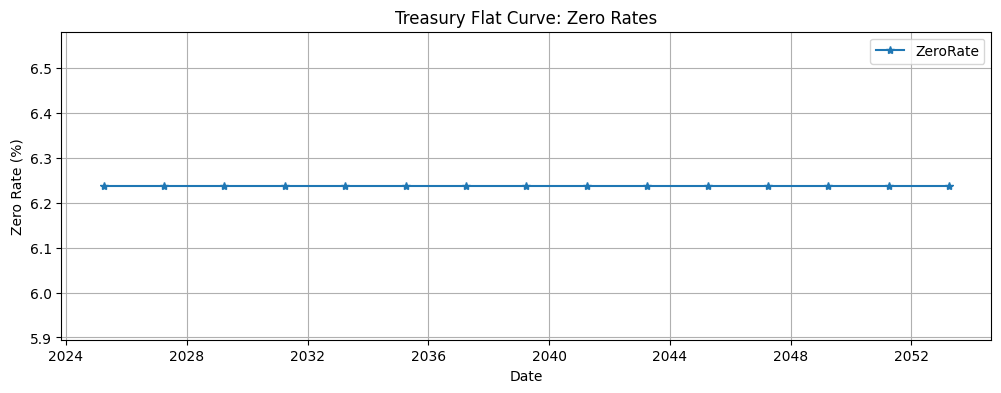

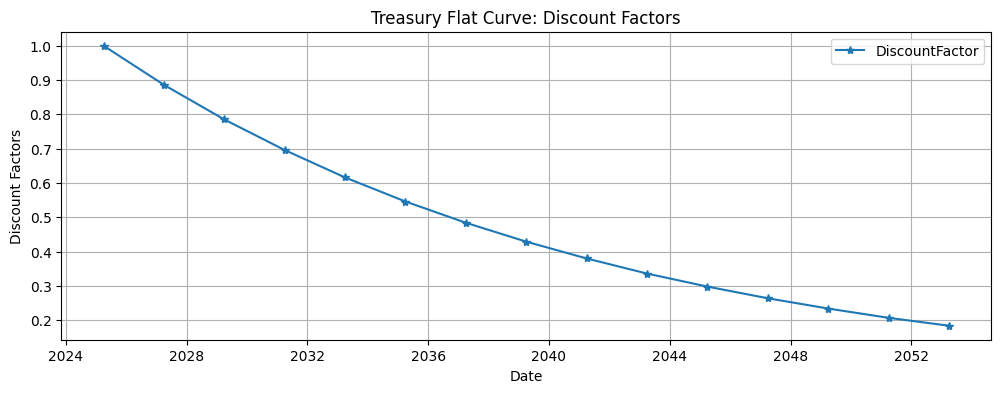

In [147]:
plt = tsy_flat_yield_curve_details_df.plot(x='Date', y='ZeroRate', grid=True, style='*-', title='Treasury Flat Curve: Zero Rates', figsize=(12,4))
plt.set_ylabel('Zero Rate (%)')
plt.set_xlabel('Date')

plt = tsy_flat_yield_curve_details_df.plot(x='Date', y='DiscountFactor', grid=True, style='*-', title='Treasury Flat Curve: Discount Factors', figsize=(12,4))
plt.set_ylabel('Discount Factors')
plt.set_xlabel('Date')

## d. Reprice the bond on the yield curve to validate the calibration 



In [213]:
# 1. Price risk-free bond
risk_free_bond_engine = ql.DiscountingBondEngine(tsy_yield_curve_handle)

fixed_rate_bond.setPricingEngine(risk_free_bond_engine)
risk_free_bond_price = fixed_rate_bond.cleanPrice()
risk_free_bond_yield = fixed_rate_bond.bondYield(risk_free_bond_price, fixed_rate_bond.dayCounter(), compounding, coupon_freq) * 100

print('tsy_clean_price_quote:', tsy_clean_price_quote)
print('risk_free_bond_price:', risk_free_bond_price)
print('price_calibration_error:', risk_free_bond_price-tsy_clean_price_quote)
print('risk_free_bond_yield:', risk_free_bond_yield)


tsy_clean_price_quote: 96.0
risk_free_bond_price: 96.00000000000001
price_calibration_error: 1.4210854715202004e-14
risk_free_bond_yield: 6.143740415573119
